In [14]:
!pip install pymysql
!sudo apt-get install -y fonts-nanum # 나눔 폰트 설치 (설치 후 런타임 재시작하고 코드 실행)
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory

In [16]:
import itertools
import pandas as pd
from sqlalchemy import create_engine
import pymysql
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.font_manager as fm
from matplotlib import rc
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import sys, os, time
from glob import glob

warnings.filterwarnings(action='ignore')
mpl.rcParams['axes.unicode_minus'] = False
rc('font', family='NanumBarunGothic')

endpoint = 'dao.c51deksujiip.ap-northeast-2.rds.amazonaws.com'
schema = 'dao'
db_connection_str = 'mysql+pymysql://admin:ekfkawnl@{}/{}'.format(endpoint, schema)
try :
    db_connection = create_engine(db_connection_str)
    conn = db_connection.connect()
except :
    print('fail to connect db')

def load_data_from_rds(tabel_name):
  sql = "SELECT * FROM {}".format(tabel_name)
  df = pd.read_sql(sql, db_connection)
  return df

In [17]:
def preprocess_df(df, onehot_col=None, scaling_col=None, drop_col = None, labeling_col = None, scaling_func=MinMaxScaler) :
    """
    :param df: 사용할 데이터프레임
    :param onehot_col: default = None, 원핫인코딩할 컬럼 리스트
    :param scaling_col: default = None, 스케일링할 컬럼 리스트
    :param drop_col: default = None, 사용하지 않을 컬럼 리스트
    :param labeling_col: default = None, 라벨링이 필요한 컬럼 리스트
    :param scaling_func: 스케일링시 사용할 컬럼, MinMaxScaler or StandardScaler
    :return: 전처리 된 데이터 프레임
    """
    if drop_col is not None :
        df = df.drop(drop_col, axis=1)
    if onehot_col is not None:
        df = pd.get_dummies(df, colums=onehot_col)
    if scaling_col is not None :
        for c in scaling_col :
            scaler = scaling_func()
            scaler.fit(df[[c]])
            df[c] = scaler.transform(df[[c]])
    if labeling_col is not None :
        for c in labeling_col :
            encoder = LabelEncoder()
            encoder.fit(df[c])
            df[c] = encoder.transform(df[c])
    return df

In [18]:
def plot_confusion_matrix(cm, target_names=None, cmap=None, normalize=True, labels=True, title='Confusion matrix'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)

    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [33]:
def logistic_regreesion_result(df, file_name, feature_importance = False, optimizing = False):
    train_x, test_x, train_y, test_y = train_test_split(df.drop('생태통로_효율성', axis=1), df['생태통로_효율성'], test_size=0.2, stratify=df['생태통로_효율성'])
    lr_clf = LogisticRegression()
    if optimizing :
        parameters = {
            
            'penalty': ['l1','l2','elasticnet','none'],
            'C': np.arange(0,1,0.1),
            'random_state': range(3,7,2)
        }
        start = time.time()
        # Logistic Regression
        grid_cv = GridSearchCV(lr_clf, param_grid=parameters, n_jobs=-1, scoring='accuracy', cv=5)
        grid_cv.fit(train_x, train_y)
        print('GridSearch 수행시간 : ', time.time()-start)
        print('최적 하이퍼 파라미터 :',grid_cv.best_params_)
        best_cv = grid_cv.best_estimator_

        # GridSearchCV의 최적 하이퍼파라미터로 학습된 Estimator로 예측 및 평가 수행
        pred = best_cv.predict(test_x)
        lr_clf = best_cv
    else:
        lr_clf.fit(train_x, train_y)
        pred = lr_clf.predict(test_x)

    print('정확도 : ', accuracy_score(pred, test_y))
    print('f1 score :', f1_score(y_true=test_y, y_pred=pred, average=None))
    print('f1 score average :', f1_score(y_true=test_y, y_pred=pred, average='macro'))

    # 혼동행렬
    cm =confusion_matrix(test_y, pred)
    plot_confusion_matrix(cm, target_names=list(df['생태통로_효율성'].unique()), cmap='Blues', title='{} confusion matrix'.format(file_name))

    if feature_importance :
        importances = lr_clf.feature_importances_
        std = np.std([tree.feature_importances_ for tree in lr_clf.estimators_], axis=0)
        indices = np.argsort(importances)[::-1]

        print('Feature Ranking:')
        for f in range(train_x.shape[1]) :
            print('{}. feature {} ({:3f})'.format(f+1, train_x.columns[indices][f], importances[indices[f]]))
            if f == 10 :
              break

        plt.title('Feature importances')
        plt.bar(range(train_x.shape[1]), importances[indices],
                color='r', yerr=std[indices])
        plt.xlim([-1, train_x.shape[1]])
        plt.xticks(rotation=45)
        plt.show()

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
overpass_list = glob('/content/drive/MyDrive/Colab Notebooks/데청캠_2팀/MainData/prepro/*overpass*.csv')
overpass_list = [p.replace('\\', '/') for p in overpass_list]
print(overpass_list)
tunnel_list = glob('/content/drive/MyDrive/Colab Notebooks/데청캠_2팀/MainData/prepro/*tunnel*.csv')
tunnel_list = [p.replace('\\', '/') for p in tunnel_list]
print(tunnel_list)

['/content/drive/MyDrive/Colab Notebooks/데청캠_2팀/MainData/prepro/overpass_knn2_median.csv', '/content/drive/MyDrive/Colab Notebooks/데청캠_2팀/MainData/prepro/overpass_knn5_drop.csv', '/content/drive/MyDrive/Colab Notebooks/데청캠_2팀/MainData/prepro/overpass_knn3_median.csv', '/content/drive/MyDrive/Colab Notebooks/데청캠_2팀/MainData/prepro/overpass_knn5_median.csv', '/content/drive/MyDrive/Colab Notebooks/데청캠_2팀/MainData/prepro/overpass_mean_drop.csv', '/content/drive/MyDrive/Colab Notebooks/데청캠_2팀/MainData/prepro/overpass_mean_median.csv', '/content/drive/MyDrive/Colab Notebooks/데청캠_2팀/MainData/prepro/overpass_knn2_drop.csv', '/content/drive/MyDrive/Colab Notebooks/데청캠_2팀/MainData/prepro/overpass_knn1_drop.csv', '/content/drive/MyDrive/Colab Notebooks/데청캠_2팀/MainData/prepro/overpass_knn3_drop.csv', '/content/drive/MyDrive/Colab Notebooks/데청캠_2팀/MainData/prepro/overpass_knn4_median.csv', '/content/drive/MyDrive/Colab Notebooks

In [26]:
onehot_col = ['지형기호(2.3km)', '최우점식물군락']
scaling_col = ['폭(m)', '연장(m)', '주변 로드킬 빈도', '산책로까지의 최단 거리(km)', '농가까지의 거리(km)', '도로 최고제한속도(km/h)',
               '하천거리(km)', '주변 동물종 개수', '등산로까지 최단거리(km)', '유도울타리_연장_m', '유도울타리_높이_m', '교통량', '건물까지거리(km)']
drop_col = ['번호', '위도', '경도', '생태통로_유형', '이용확인종_수', '유도울타리_위도_2.3km', '유도울타리_경도_2.3km', '식물군락명']
scaling_col_tunnel = scaling_col + ['높이(m)', '개방도']

# 육교형

GridSearch 수행시간 :  11.954760551452637
최적 하이퍼 파라미터 : {'C': 0.5, 'penalty': 'l2', 'random_state': 3}
정확도 :  0.6666666666666666
f1 score : [0.625      0.8        0.34782609]
f1 score average : 0.5909420289855073


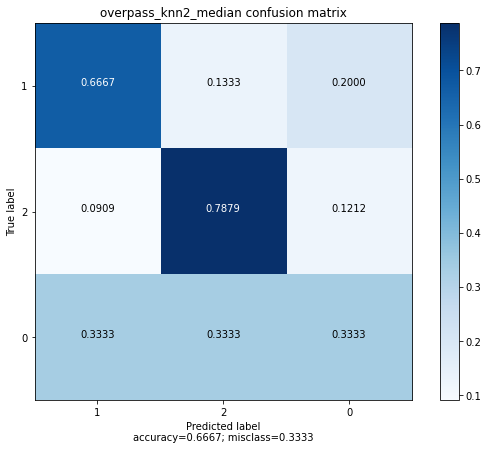

GridSearch 수행시간 :  17.315128803253174
최적 하이퍼 파라미터 : {'C': 0.0, 'penalty': 'l2', 'random_state': 3}
정확도 :  0.40540540540540543
f1 score : [0.57692308 0.         0.        ]
f1 score average : 0.1923076923076923


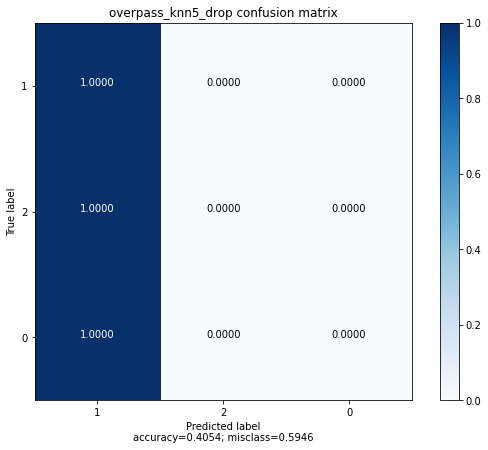

GridSearch 수행시간 :  13.836027145385742
최적 하이퍼 파라미터 : {'C': 0.0, 'penalty': 'none', 'random_state': 3}
정확도 :  0.6333333333333333
f1 score : [0.51612903 0.77142857 0.31578947]
f1 score average : 0.5344490257902822


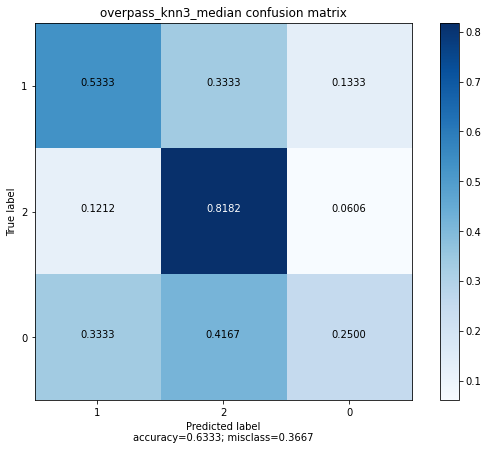

GridSearch 수행시간 :  19.257718563079834
최적 하이퍼 파라미터 : {'C': 0.1, 'penalty': 'l2', 'random_state': 3}
정확도 :  0.65
f1 score : [0.57894737 0.79365079 0.31578947]
f1 score average : 0.5627958785853524


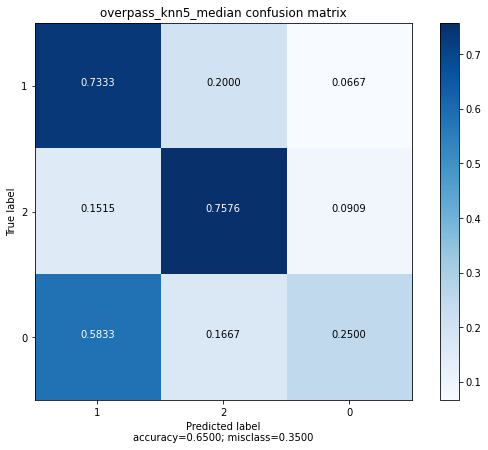

GridSearch 수행시간 :  11.325056314468384
최적 하이퍼 파라미터 : {'C': 0.0, 'penalty': 'l2', 'random_state': 3}
정확도 :  0.40540540540540543
f1 score : [0.57692308 0.         0.        ]
f1 score average : 0.1923076923076923


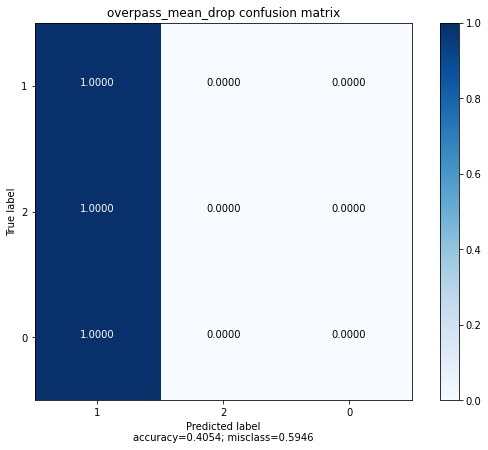

GridSearch 수행시간 :  19.426875114440918
최적 하이퍼 파라미터 : {'C': 0.0, 'penalty': 'none', 'random_state': 3}
정확도 :  0.5833333333333334
f1 score : [0.51282051 0.72131148 0.3       ]
f1 score average : 0.5113773294101163


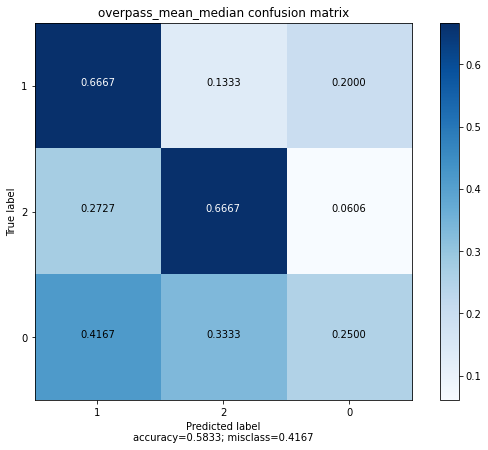

GridSearch 수행시간 :  10.384289979934692
최적 하이퍼 파라미터 : {'C': 0.0, 'penalty': 'l2', 'random_state': 3}
정확도 :  0.40540540540540543
f1 score : [0.57692308 0.         0.        ]
f1 score average : 0.1923076923076923


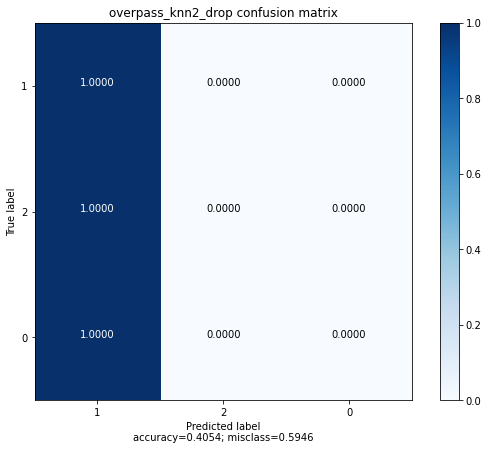

GridSearch 수행시간 :  15.251886129379272
최적 하이퍼 파라미터 : {'C': 0.0, 'penalty': 'l2', 'random_state': 3}
정확도 :  0.40540540540540543
f1 score : [0.57692308 0.         0.        ]
f1 score average : 0.1923076923076923


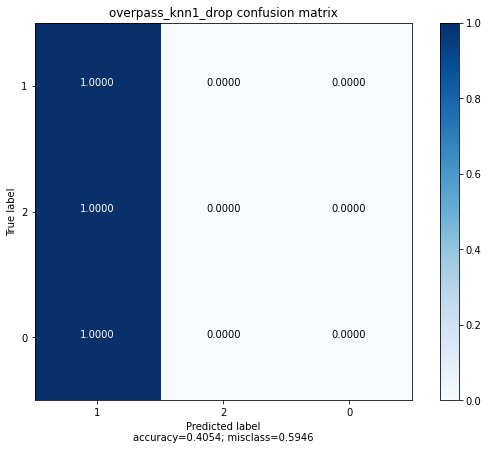

GridSearch 수행시간 :  16.78944182395935
최적 하이퍼 파라미터 : {'C': 0.0, 'penalty': 'l2', 'random_state': 3}
정확도 :  0.40540540540540543
f1 score : [0.57692308 0.         0.        ]
f1 score average : 0.1923076923076923


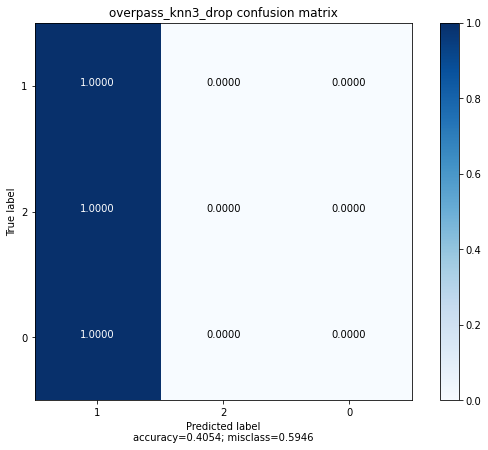

In [ ]:
for case in overpass_list :
    df = pd.read_csv(case, encoding='cp949')
    name = case.split('/')[-1].split('.')[0]
    # print(df.columns)
    df = preprocess_df(df, drop_col=drop_col, labeling_col=onehot_col, scaling_col=scaling_col, scaling_func=StandardScaler)
    # print(df.columns)
    logistic_regreesion_result(df, file_name=name, optimizing=True)


# 터널형

In [23]:
for case in tunnel_list :
    df = pd.read_csv(case, encoding='cp949')
    name = case.split('/')[-1].split('.')[0]
    # print(df.columns)
    df = preprocess_df(df, drop_col=drop_col, labeling_col=onehot_col, scaling_col=scaling_col_tunnel, scaling_func=StandardScaler)
    # print(df.columns)
    logistic_regreesion_result(df, file_name=name, optimizing=True)
